In [1]:
"""
Created on Wed Aug  4 17:50:06 2021

@author: Amol & Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
from main import *
debug_mode = True  # faster experiments for debugging

# util for getting objects' fields' names
field_names = lambda x: list(vars(x).keys())

In [2]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer()
dp.createPCAs()
dp.sparsePCAs()
dp.zmixOrthogonalPCAs()
df = dp.getDataframe()

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)

In [3]:
'''
Run the Model Experiments
'''

"""
model = 'PCDNN_V2'
assert model in ['PCDNN_V2', 'PCDNN_V1', 'SIMPLE_DNN', 'GP'] # valid possible models
exprExec=run_model_experiments(dm, models=model, debug_mode=debug_mode)
"""
exprExec = run_pcdnn_v2_experiments(dm, use_dependants=True, debug_mode = debug_mode)

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated
=================== randomequalflamesplit ===================
------------------ AllSpecies ------------------
--------------------self.build_and_compile_pcdnn_v2_model----------------------
train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7309, 3217, 13527, 14989, 4849, 9944, 11018, 8974, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 29198, 12208, 3752, 14239, 2620]
test_set_keys:  [2246, 2758, 3056, 2364, 21463, 2027, 4376, 2903, 26352, 30735, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 7694, 6597, 5104, 22593, 4606]
train:  [ 3752 11018  3217  2620 25034]
test:  [ 2903 11598 27738  5104  4157]
53 2 N Y Y Y
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 species_input (InputLayer)  [(None, 53)]              0         
                                            

KeyboardInterrupt: 

In [ ]:
""" prepare SimpleDNN for loading (from prior experiments) """

exprExec = DNNExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(SimpleDNNModelFactory())

In [ ]:
""" prepare PCDNNV1 for loading (from prior experiments) """

exprExec = PCDNNV1ExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(PCDNNV1ModelFactory())

In [3]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(PCDNNV2ModelFactory())

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


## Rapid Model Testing: 
### (requires setting up PCDNNV2 for loading)

In [4]:
# fix seeds
import random
import numpy as np
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

dataType = 'randomequaltraintestsplit' #'frameworkincludedtrainexcludedtest'
inputType = 'AllSpeciesAndZmix'
dependants = 'NoDependants'
dataSetMethod = f'{inputType}_{dataType}_{dependants}'
opscaler=ipscaler="MinMaxScaler"# 'PositiveLogNormal'
#opscaler=None
ZmixPresent = 'N'
concatenateZmix = 'N'
kernel_constraint = 'N'
kernel_regularizer = 'N'
activity_regularizer = 'N'
noOfCpv = 4
noOfNeurons = 53

exprExec.modelFactory.loss='mae'
exprExec.modelFactory.activation_func='relu'
exprExec.modelFactory.dropout_rate=0.5
exprExec.debug_mode = False
exprExec.use_dependants = True
exprExec.use_dynamic_pred = True
exprExec.epochs_override = 100
exprExec.batch_size = 64
exprExec.n_models_override = 1

# initialize experiment executor...
exprExec.dm = dm
exprExec.df_experimentTracker = pd.DataFrame()
exprExec.modelType = 'PCDNNV2'

history = exprExec.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent=ZmixPresent,
                                           noOfCpv=noOfCpv,concatenateZmix=concatenateZmix,kernel_constraint=kernel_constraint,
                                           kernel_regularizer=kernel_regularizer,activity_regularizer=activity_regularizer,
                                           opscaler=opscaler, ipscaler=ipscaler)

--------------------self.build_and_compile_pcdnn_v2_model----------------------
53 4 N N N N


2022-03-03 01:02:55.766760: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 01:02:56.175191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14201 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


Model: "container_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 species_input (InputLayer)     [(None, 53)]         0           []                               
                                                                                                  
 source_term_input (InputLayer)  [(None, 53)]        0           []                               
                                                                                                  
 emb_and_regression_model (Func  {'static_source_pre  350141     ['species_input[0][0]']          
 tional)                        diction': (None, 1)                                               
                                , 'dynamic_source_p                                               
                                rediction': (None,                                  

|| linear_embedding (Dense)   (None, 4)            216         []                               ||
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 dynamic_source_prediction (Con  (None, 8)           0           ['emb_and_regression_model[0][0]'
 catenate)                                                       , 'source_term_truth[0][0]']     
                                                                                                  
Total params: 350,141
Trainable params: 350,141
Non-trainable params: 0
__________________________________________________________________________________________________
53 4 N N N N
training model: 1
Epoch 1/100
//: 4, /: 4.0
//: 4, /: 4.0
129/129 [==============================] - 4s 18ms/step - loss: 7816.7051 - dynamic_source_prediction_loss: 7814.7925 - emb_and_regression_model_loss: 1.9150 - dyna

Epoch 9/100
129/129 [==============================] - 2s 16ms/step - loss: 467.8794 - dynamic_source_prediction_loss: 466.3292 - emb_and_regression_model_loss: 1.5503 - dynamic_source_prediction_R2_split: -283.4028 - dynamic_source_prediction_source_pred_mean: -298.2838 - dynamic_source_prediction_source_true_mean: -302.8432 - emb_and_regression_model_mae: 1.5503 - emb_and_regression_model_mse: 13.9825 - emb_and_regression_model_R2: -952.5142 - val_loss: 458.9790 - val_dynamic_source_prediction_loss: 457.4244 - val_emb_and_regression_model_loss: 1.5546 - val_dynamic_source_prediction_R2_split: -34.1020 - val_dynamic_source_prediction_source_pred_mean: -371.7072 - val_dynamic_source_prediction_source_true_mean: -288.4865 - val_emb_and_regression_model_mae: 1.5546 - val_emb_and_regression_model_mse: 7.8610 - val_emb_and_regression_model_R2: -589.2068
Epoch 10/100
129/129 [==============================] - 2s 17ms/step - loss: 423.9875 - dynamic_source_prediction_loss: 422.5783 - emb_and

129/129 [==============================] - 2s 16ms/step - loss: 259.1401 - dynamic_source_prediction_loss: 257.6275 - emb_and_regression_model_loss: 1.5126 - dynamic_source_prediction_R2_split: -151.9360 - dynamic_source_prediction_source_pred_mean: -230.0185 - dynamic_source_prediction_source_true_mean: -236.9881 - emb_and_regression_model_mae: 1.5126 - emb_and_regression_model_mse: 17.3006 - emb_and_regression_model_R2: -1133.7479 - val_loss: 257.4431 - val_dynamic_source_prediction_loss: 256.5376 - val_emb_and_regression_model_loss: 0.9055 - val_dynamic_source_prediction_R2_split: -454.3348 - val_dynamic_source_prediction_source_pred_mean: -248.2233 - val_dynamic_source_prediction_source_true_mean: -248.7282 - val_emb_and_regression_model_mae: 0.9055 - val_emb_and_regression_model_mse: 3.4639 - val_emb_and_regression_model_R2: -221.6318
Epoch 19/100
129/129 [==============================] - 2s 16ms/step - loss: 241.9831 - dynamic_source_prediction_loss: 240.3554 - emb_and_regressio

129/129 [==============================] - 2s 16ms/step - loss: 182.1332 - dynamic_source_prediction_loss: 181.2405 - emb_and_regression_model_loss: 0.8927 - dynamic_source_prediction_R2_split: -146.2542 - dynamic_source_prediction_source_pred_mean: -173.1922 - dynamic_source_prediction_source_true_mean: -185.7575 - emb_and_regression_model_mae: 0.8927 - emb_and_regression_model_mse: 4.7135 - emb_and_regression_model_R2: -294.7482 - val_loss: 178.5683 - val_dynamic_source_prediction_loss: 177.8465 - val_emb_and_regression_model_loss: 0.7217 - val_dynamic_source_prediction_R2_split: -84.1056 - val_dynamic_source_prediction_source_pred_mean: -170.3145 - val_dynamic_source_prediction_source_true_mean: -166.8371 - val_emb_and_regression_model_mae: 0.7217 - val_emb_and_regression_model_mse: 2.1907 - val_emb_and_regression_model_R2: -152.0415
Epoch 28/100
129/129 [==============================] - 2s 16ms/step - loss: 172.6872 - dynamic_source_prediction_loss: 171.6009 - emb_and_regression_m

129/129 [==============================] - 2s 16ms/step - loss: 133.1887 - dynamic_source_prediction_loss: 132.1147 - emb_and_regression_model_loss: 1.0740 - dynamic_source_prediction_R2_split: -60.3996 - dynamic_source_prediction_source_pred_mean: -135.4615 - dynamic_source_prediction_source_true_mean: -141.9317 - emb_and_regression_model_mae: 1.0740 - emb_and_regression_model_mse: 7.0931 - emb_and_regression_model_R2: -510.4801 - val_loss: 141.4403 - val_dynamic_source_prediction_loss: 140.8093 - val_emb_and_regression_model_loss: 0.6309 - val_dynamic_source_prediction_R2_split: -131.1372 - val_dynamic_source_prediction_source_pred_mean: -124.3880 - val_dynamic_source_prediction_source_true_mean: -159.2534 - val_emb_and_regression_model_mae: 0.6309 - val_emb_and_regression_model_mse: 2.0874 - val_emb_and_regression_model_R2: -141.9114
Epoch 37/100
129/129 [==============================] - 2s 16ms/step - loss: 134.2398 - dynamic_source_prediction_loss: 133.4134 - emb_and_regression_m

Epoch 46/100
129/129 [==============================] - 2s 16ms/step - loss: 108.4139 - dynamic_source_prediction_loss: 107.8200 - emb_and_regression_model_loss: 0.5938 - dynamic_source_prediction_R2_split: -64.3619 - dynamic_source_prediction_source_pred_mean: -81.6611 - dynamic_source_prediction_source_true_mean: -85.4256 - emb_and_regression_model_mae: 0.5938 - emb_and_regression_model_mse: 1.9182 - emb_and_regression_model_R2: -145.4141 - val_loss: 99.4037 - val_dynamic_source_prediction_loss: 98.8501 - val_emb_and_regression_model_loss: 0.5537 - val_dynamic_source_prediction_R2_split: -11.7471 - val_dynamic_source_prediction_source_pred_mean: -92.7368 - val_dynamic_source_prediction_source_true_mean: -93.0310 - val_emb_and_regression_model_mae: 0.5537 - val_emb_and_regression_model_mse: 1.2029 - val_emb_and_regression_model_R2: -79.0374
Epoch 47/100
129/129 [==============================] - 2s 16ms/step - loss: 103.3510 - dynamic_source_prediction_loss: 102.6820 - emb_and_regress

Epoch 56/100
129/129 [==============================] - 2s 16ms/step - loss: 88.0565 - dynamic_source_prediction_loss: 87.5256 - emb_and_regression_model_loss: 0.5308 - dynamic_source_prediction_R2_split: -72.2160 - dynamic_source_prediction_source_pred_mean: -52.5463 - dynamic_source_prediction_source_true_mean: -52.2473 - emb_and_regression_model_mae: 0.5308 - emb_and_regression_model_mse: 1.6133 - emb_and_regression_model_R2: -104.5471 - val_loss: 95.4853 - val_dynamic_source_prediction_loss: 95.0406 - val_emb_and_regression_model_loss: 0.4447 - val_dynamic_source_prediction_R2_split: -286.8801 - val_dynamic_source_prediction_source_pred_mean: -50.7618 - val_dynamic_source_prediction_source_true_mean: -49.1701 - val_emb_and_regression_model_mae: 0.4447 - val_emb_and_regression_model_mse: 0.6480 - val_emb_and_regression_model_R2: -44.3068
Epoch 57/100
129/129 [==============================] - 2s 16ms/step - loss: 82.5167 - dynamic_source_prediction_loss: 81.9967 - emb_and_regression

Epoch 66/100
129/129 [==============================] - 2s 16ms/step - loss: 66.7219 - dynamic_source_prediction_loss: 66.3406 - emb_and_regression_model_loss: 0.3813 - dynamic_source_prediction_R2_split: -61.6263 - dynamic_source_prediction_source_pred_mean: -39.6299 - dynamic_source_prediction_source_true_mean: -40.6710 - emb_and_regression_model_mae: 0.3813 - emb_and_regression_model_mse: 0.7273 - emb_and_regression_model_R2: -43.5985 - val_loss: 94.9302 - val_dynamic_source_prediction_loss: 94.6817 - val_emb_and_regression_model_loss: 0.2485 - val_dynamic_source_prediction_R2_split: -33.2706 - val_dynamic_source_prediction_source_pred_mean: -19.9083 - val_dynamic_source_prediction_source_true_mean: -55.9489 - val_emb_and_regression_model_mae: 0.2485 - val_emb_and_regression_model_mse: 0.2298 - val_emb_and_regression_model_R2: -12.8542
Epoch 67/100
129/129 [==============================] - 2s 17ms/step - loss: 68.6483 - dynamic_source_prediction_loss: 68.2713 - emb_and_regression_m

Epoch 76/100
129/129 [==============================] - 2s 18ms/step - loss: 51.4816 - dynamic_source_prediction_loss: 51.2301 - emb_and_regression_model_loss: 0.2515 - dynamic_source_prediction_R2_split: -62.5275 - dynamic_source_prediction_source_pred_mean: -40.8849 - dynamic_source_prediction_source_true_mean: -39.1547 - emb_and_regression_model_mae: 0.2515 - emb_and_regression_model_mse: 0.2434 - emb_and_regression_model_R2: -14.2771 - val_loss: 49.4308 - val_dynamic_source_prediction_loss: 48.9961 - val_emb_and_regression_model_loss: 0.4347 - val_dynamic_source_prediction_R2_split: -4.4569 - val_dynamic_source_prediction_source_pred_mean: -43.8822 - val_dynamic_source_prediction_source_true_mean: -49.5516 - val_emb_and_regression_model_mae: 0.4347 - val_emb_and_regression_model_mse: 0.8156 - val_emb_and_regression_model_R2: -58.7221
Epoch 77/100
129/129 [==============================] - 2s 18ms/step - loss: 46.6767 - dynamic_source_prediction_loss: 46.4131 - emb_and_regression_mo

Epoch 86/100
129/129 [==============================] - 2s 18ms/step - loss: 38.5198 - dynamic_source_prediction_loss: 38.3221 - emb_and_regression_model_loss: 0.1977 - dynamic_source_prediction_R2_split: -15.8783 - dynamic_source_prediction_source_pred_mean: -44.2462 - dynamic_source_prediction_source_true_mean: -42.7921 - emb_and_regression_model_mae: 0.1977 - emb_and_regression_model_mse: 0.1537 - emb_and_regression_model_R2: -8.5295 - val_loss: 40.7333 - val_dynamic_source_prediction_loss: 40.5126 - val_emb_and_regression_model_loss: 0.2207 - val_dynamic_source_prediction_R2_split: -10.5076 - val_dynamic_source_prediction_source_pred_mean: -46.1986 - val_dynamic_source_prediction_source_true_mean: -41.4932 - val_emb_and_regression_model_mae: 0.2207 - val_emb_and_regression_model_mse: 0.1534 - val_emb_and_regression_model_R2: -10.0836
Epoch 87/100
129/129 [==============================] - 2s 18ms/step - loss: 37.8313 - dynamic_source_prediction_loss: 37.6436 - emb_and_regression_mo

Epoch 96/100
129/129 [==============================] - 2s 18ms/step - loss: 36.8045 - dynamic_source_prediction_loss: 36.6191 - emb_and_regression_model_loss: 0.1855 - dynamic_source_prediction_R2_split: -15.7893 - dynamic_source_prediction_source_pred_mean: -44.4101 - dynamic_source_prediction_source_true_mean: -43.5891 - emb_and_regression_model_mae: 0.1855 - emb_and_regression_model_mse: 0.1332 - emb_and_regression_model_R2: -7.5106 - val_loss: 40.6865 - val_dynamic_source_prediction_loss: 40.4740 - val_emb_and_regression_model_loss: 0.2125 - val_dynamic_source_prediction_R2_split: -10.3888 - val_dynamic_source_prediction_source_pred_mean: -48.0757 - val_dynamic_source_prediction_source_true_mean: -45.6716 - val_emb_and_regression_model_mae: 0.2125 - val_emb_and_regression_model_mse: 0.1729 - val_emb_and_regression_model_R2: -11.9630
Epoch 97/100
129/129 [==============================] - 2s 18ms/step - loss: 36.5661 - dynamic_source_prediction_loss: 36.3817 - emb_and_regression_mo

/home/dwyerdei/rom_project2/src/data/pre_processing.py:116: UserWarning: model error is only recored for souener prediction
  warnings.warn('model error is only recored for souener prediction')


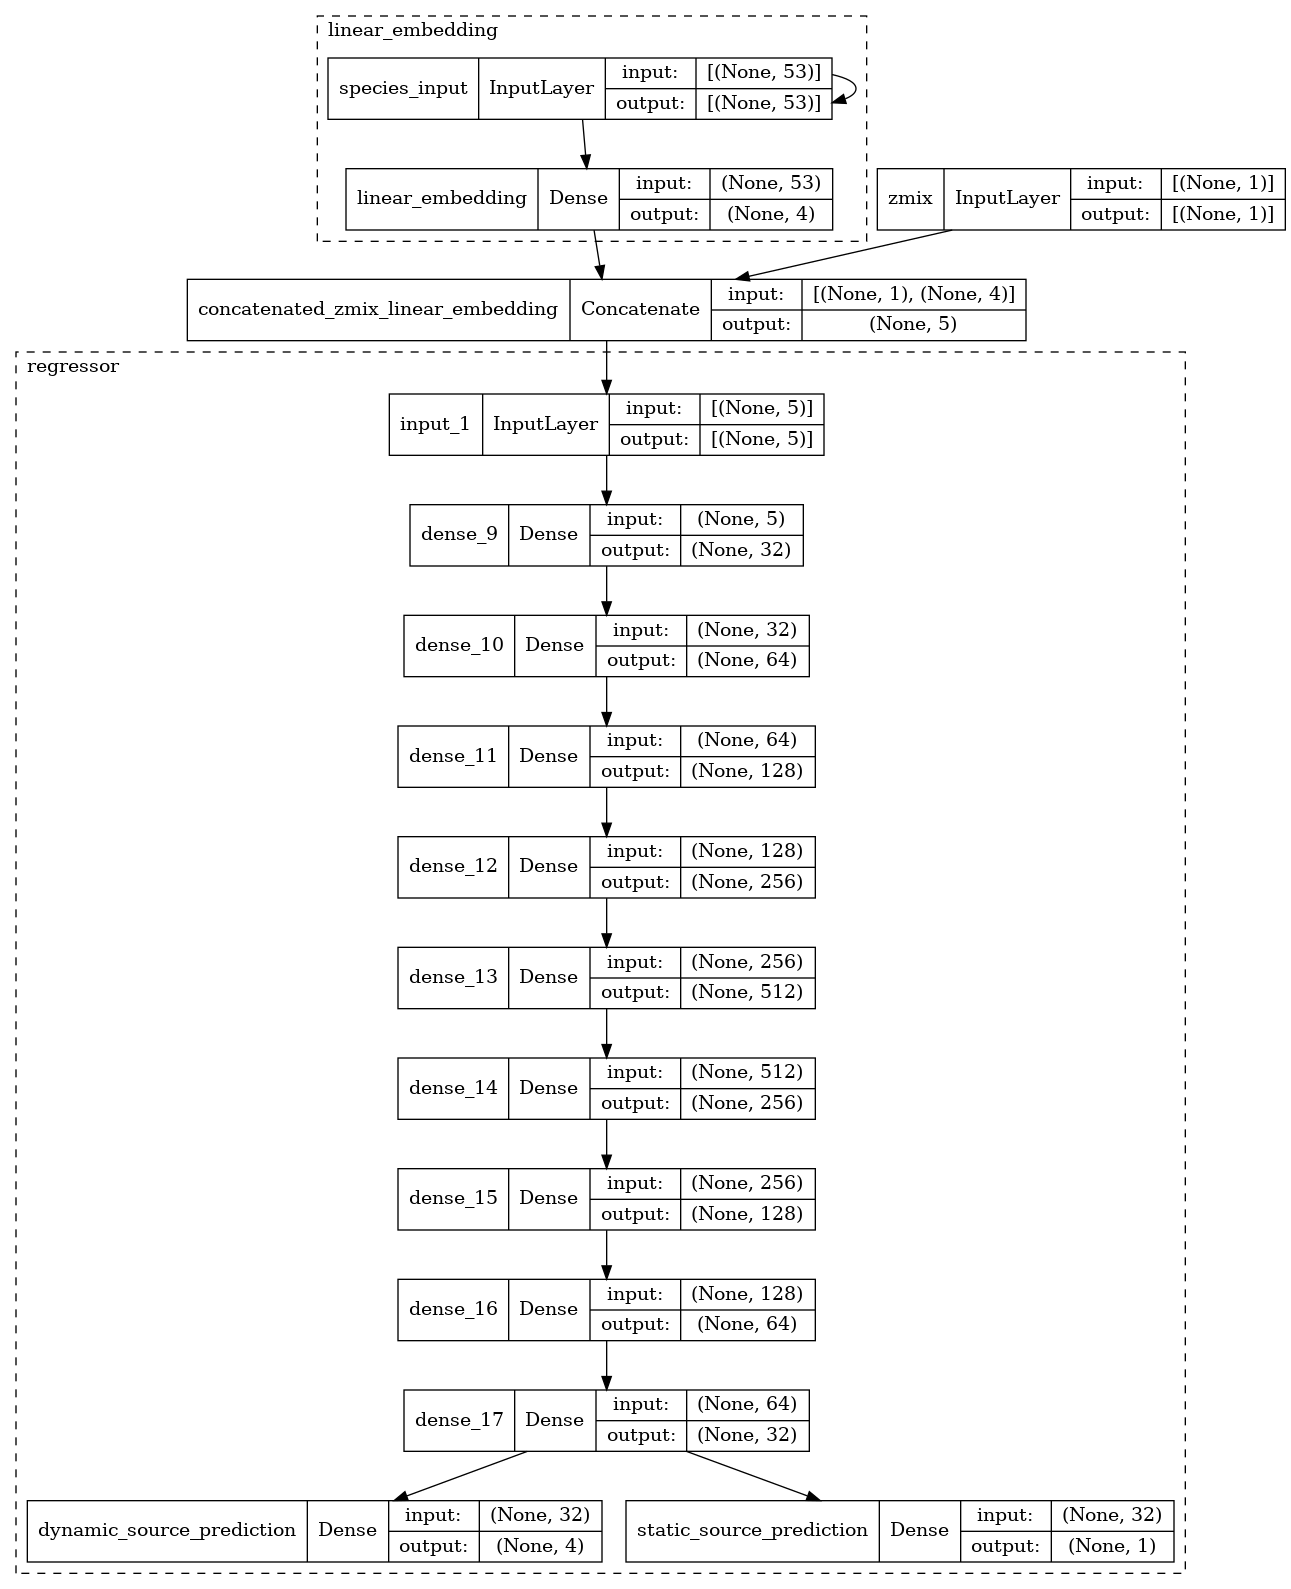

In [5]:
exprExec.modelFactory.model.save('souener_only_model_template.h5', include_optimizer=True)
tf.keras.utils.plot_model(exprExec.modelFactory.model, expand_nested=True, show_shapes=True)

## Results Plotting & Analysis

In [6]:
loss = 727684307.3417714 # Update Me!

def print_scientific_notation(number):
    power = int(np.log(number)/np.log(10))
    print(f"Scientific Notation: {(loss/10**power)}*10^{power}")
print_scientific_notation(loss)

Scientific Notation: 7.276843073417714*10^8


In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.plot(np.maximum(history.history['val_R2'][30:], 0))
plt.title('val_R^2 vs epochs')
plt.ylabel('percent')
plt.xlabel('epochs')
plt.show()

NameError: name 'history' is not defined

In [6]:
from sklearn.preprocessing import MaxAbsScaler
ipscaler = MaxAbsScaler()
#ipscaler.fit(dm.X_train)
ipscaler.fit(dm.X_test)
X_train_norm=ipscaler.transform(dm.X_train)

In [31]:
linear_embedder = bestModel.get_layer('linear_embedding')
batch = linear_embedder.get_layer('batch_normalization_1')
del batch.weights[0]

In [47]:
weights = [batch.weights[1], batch.weights[2]]
W = np.diag(np.ones_like(weights[1]))[:, :4]
sigma_scale_mat = np.diag(1/weights[1])
W = (W.T.dot(sigma_scale_mat)).T
vec_bias = weights[0].numpy().reshape(-1, 1)
print(vec_bias)

[[-1.2197605e+02]
 [ 2.7441608e+02]
 [ 3.9276913e+02]
 [-3.7624704e+02]
 [ 2.0745377e+02]
 [ 5.5211090e+02]
 [ 7.5975020e+03]
 [ 1.1251233e+02]
 [ 5.0990376e+01]
 [ 1.5034778e+02]
 [ 6.4735794e+01]
 [ 9.0604968e+02]
 [ 4.5472218e+01]
 [ 7.4774971e+01]
 [ 2.7607706e+02]
 [ 4.0496692e+02]
 [ 2.2653084e+02]
 [ 2.3785754e+02]
 [ 2.7986859e+02]
 [ 2.4256323e+02]
 [ 1.1077673e+02]
 [ 1.5196050e+03]
 [ 1.2889904e+00]
 [ 1.5390538e+02]
 [ 1.2685127e+02]
 [ 2.8229702e+01]
 [ 2.5205489e+02]
 [ 5.6536633e+02]
 [ 1.4476831e+02]
 [ 3.6271771e+02]
 [ 9.0173548e-01]
 [ 3.3605480e-01]
 [-4.2159259e-01]
 [-2.5419772e-01]
 [ 5.2569699e-01]
 [ 5.3725308e-01]
 [ 6.4045253e+00]
 [ 4.3038118e-01]
 [ 5.1746178e-01]
 [ 5.2378339e-01]
 [-3.2580298e-01]
 [-8.9662027e-01]
 [-1.1641607e+01]
 [-5.7958567e-01]
 [-9.4777361e-02]
 [-3.1850982e-01]
 [ 6.2237501e-01]
 [ 3.8874813e+01]
 [ 2.4089511e+02]
 [ 3.7691129e+02]
 [ 1.0642928e+02]
 [ 7.5036690e-02]
 [ 5.0617293e-02]]


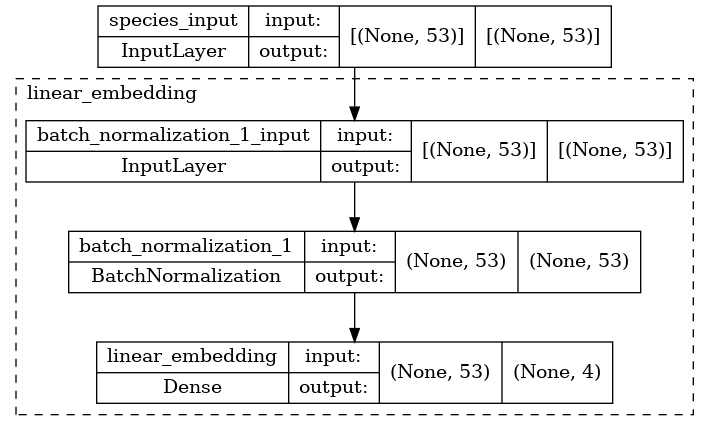

In [31]:
tf.keras.utils.plot_model(linear_embedder, expand_nested=True, show_shapes=True)

In [6]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
dm.createTrainTestData(experimentSettings['dataSetMethod'],experimentSettings['noOfCpv'], experimentSettings['ipscaler'], experimentSettings['opscaler'])

print(f'\nexperimentSettings: {experimentSettings}')
print(f'\nbestModel.input_shape: {bestModel.input_shape}')
inspector = model_analysis.ModelInspector(exprExec.modelFactory, dm)


experimentSettings: {'dataSetMethod': 'AllSpecies_randomequaltraintestsplit_NoDependants', 'ipscaler': 'MaxAbsScaler', 'opscaler': 'MaxAbsScaler', 'noOfCpv': 4, 'ZmixPresent': 'N', 'concatenateZmix': 'N', 'kernel_constraint': 'N', 'kernel_regularizer': 'N', 'activity_regularizer': 'N', 'input_data_cols': ['YiCH4', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiH2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN', 'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO', 'YiCN', 'YiHCN', 'YiH2CN', 'YiHCNN', 'YiHCNO', 'YiHOCN', 'YiHNCO', 'YiNCO', 'YiC3H7', 'YiC3H8', 'YiCH2CHO', 'YiCH3CHO', 'YiN2', 'YiAR']}

bestModel.input_shape: (None, 53)
Model: "regressor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape  

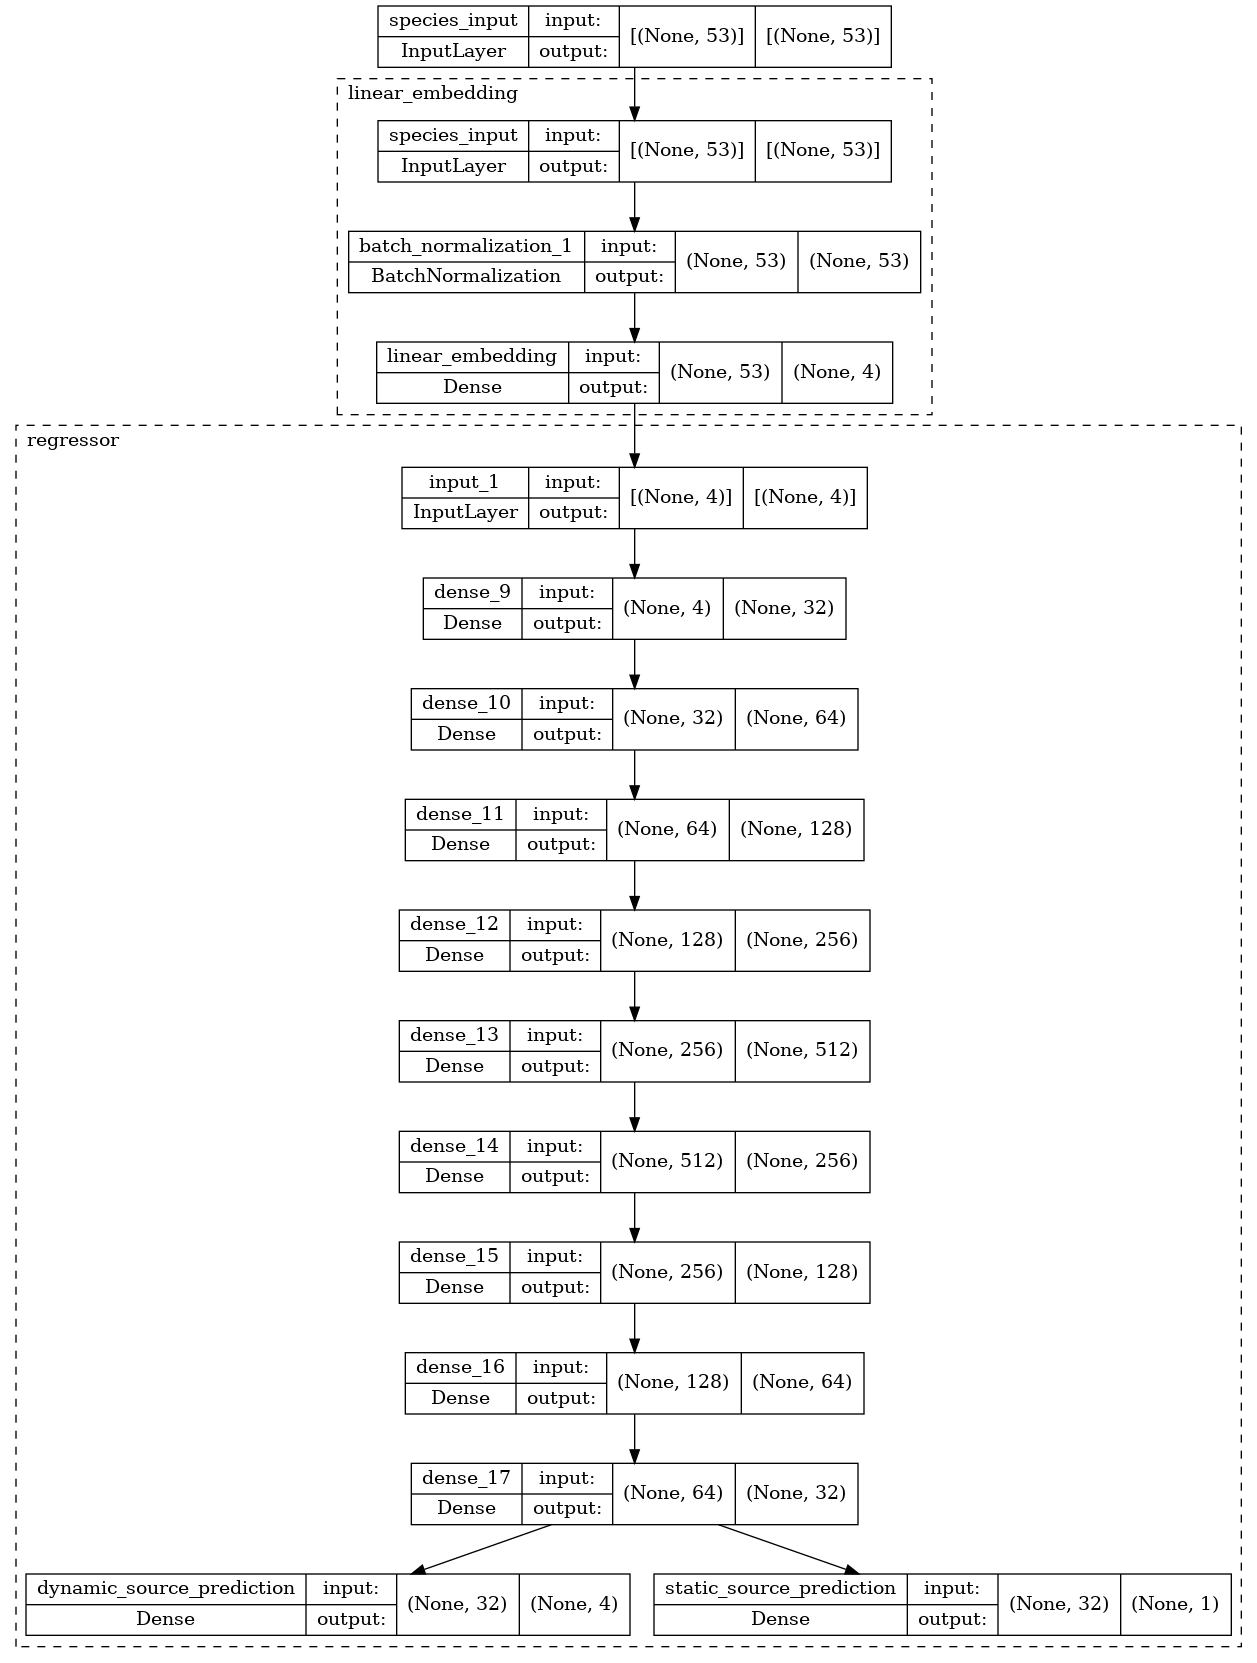

In [7]:
tf.keras.utils.plot_model(bestModel, expand_nested=True, show_shapes=True)

cpv3; 2.777211e+00 +/- 2.046654e-01
cpv1; 2.240522e+00 +/- 1.286959e-01
cpv4; 1.584013e-01 +/- 9.457981e-02
zmix; 1.095361e-01 +/- 4.154005e-02
cpv2; -7.626095e-01 +/- 5.926974e-02


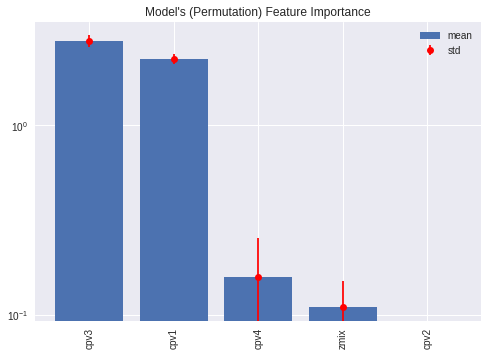

In [18]:
n_repeats = 5 if debug_mode else 20
inspector.plot_permutation_feature_importance(n_repeats=n_repeats)

In [9]:
bestModel.get_layer('linear_embedding').summary()

Model: "linear_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 species_input (InputLayer)  [(None, 53)]              0         
                                                                 
 linear_embedding (Dense)    (None, 4)                 216       
                                                                 
Total params: 216
Trainable params: 216
Non-trainable params: 0
_________________________________________________________________


         zmix      cpv1      cpv2      cpv3      cpv4
min  0.000000 -1.017909 -0.684758 -0.522741 -0.759153
25%  0.208623 -0.264934 -0.208032 -0.031693 -0.459451
50%  0.396276 -0.152544 -0.135904  0.064915 -0.170462
75%  0.636110  0.183973 -0.069132  0.307219  0.123652
max  1.000000  0.481723  0.315030  0.975328  0.368747


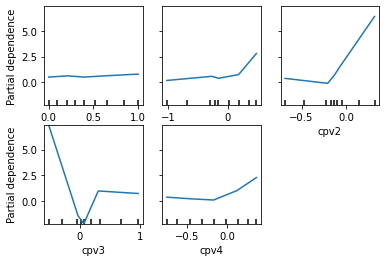

In [10]:
inspector.plot_partial_dependence()

#### Error Density by FlameId & XPos

In [11]:
def getResiduals(Y_test,Y_pred):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['actual'] = Y_test.flatten()

    evaluation_df_1['prediction'] = Y_pred.flatten()

    evaluation_df_1['res'] = evaluation_df_1['actual'] - evaluation_df_1['prediction']
   
    return evaluation_df_1['res'].values

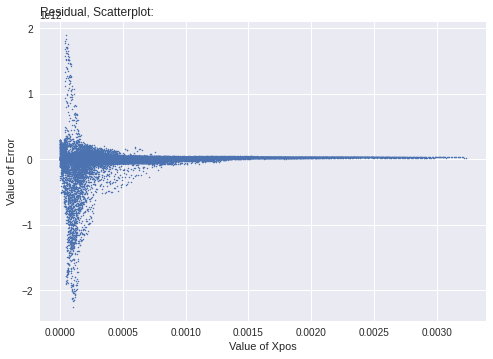

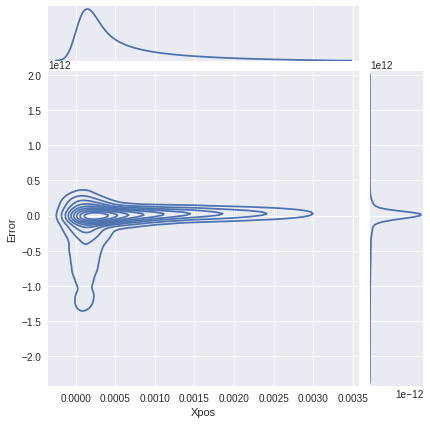

In [12]:
# TODO: Sanity check that this plots output ranges are correct? Seems like bug!

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# libraries and data
plt.style.use('seaborn')

opscaler = dm.outputScaler
df = dp.getDataframe()
X,Y,rom,Zmix = dm.getAllData()
#X_train, X_test, Y_train, Y_test, rom_train, rom_test, zmix_train, zmix_test = dm.getTrainTestData()
Y_test = Y
Y_pred = bestModel.predict({"species_input":X, "zmix":Zmix})['static_source_prediction']

# TODO: check should there be inverse transform here?
souener_pred = opscaler.inverse_transform(Y_pred)[:, dm.souener_index]
souener_test = opscaler.inverse_transform(Y_test)[:, dm.souener_index]

#residual/error

residuals = getResiduals(souener_test,souener_pred)

Xpos = df['Xpos']

plt_df = pd.DataFrame()
plt_df["Xpos"]=Xpos
plt_df["Error"] = residuals
# plot
plt.plot( 'Xpos', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Xpos')
plt.ylabel('Value of Error')
plt.title('Residual, Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Xpos, y=plt_df.Error, kind='kde')
#plt.title('Residual, Marginal Density plot:')

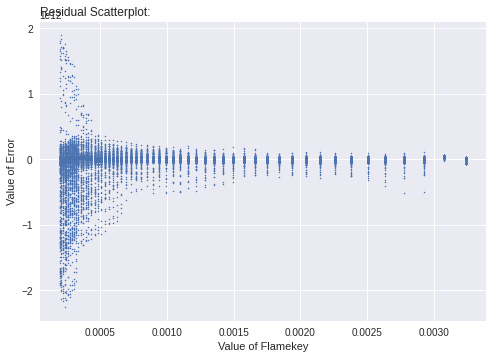

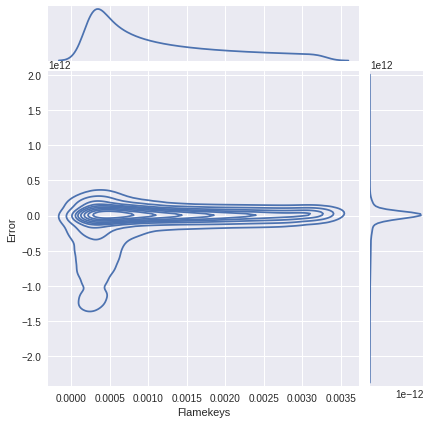

In [13]:
#residuals = getResiduals(Y_test_df['souener'].values,Y_pred_df['souener'].values)

flamekeys = df['flame_key']#np.append(halfData["flame_keys_test"],halfData["flame_keys_train"],axis=0)

plt_df = pd.DataFrame()
plt_df["Flamekeys"]=flamekeys
plt_df["Error"] = residuals
# plot
plt.plot( 'Flamekeys', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Flamekey')
plt.ylabel('Value of Error')
plt.title('Residual Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Flamekeys, y=plt_df.Error, kind='kde')

Text(0.5, 1.0, 'Y_test histogram')

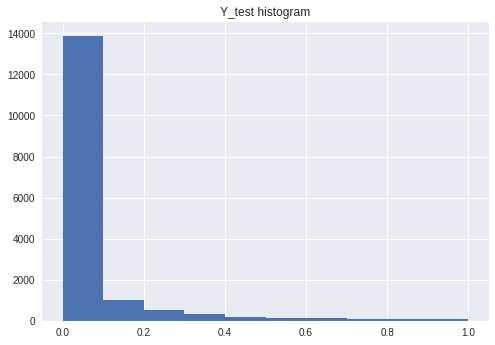

In [14]:
plt.hist(Y_test[:,0])
plt.title('Y_test histogram')

Text(0.5, 1.0, 'Y_pred histogram')

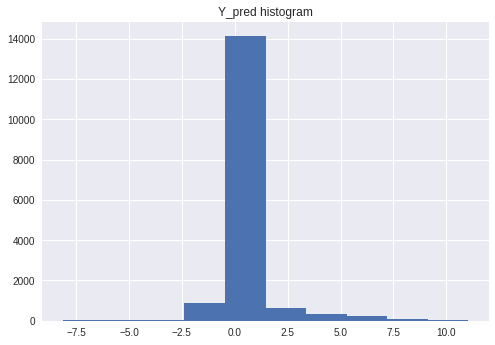

In [15]:
plt.hist(Y_pred[:,0])
plt.title('Y_pred histogram')

In [29]:
'''
from tensorflow import keras

def log_mse(x,y): return tf.math.log(tf.math.reduce_mean((x-y)**2))
def log_mae(x,y): return tf.math.log(tf.math.reduce_mean(tf.math.abs(x-y)))
def exp_mse_mag(x,y): return tf.math.log(tf.math.reduce_mean((tf.math.exp(x)-tf.math.exp(y))**2))/tf.math.log(10.0)
def exp_mae_mag(x,y): return tf.math.log(tf.math.reduce_mean(tf.math.abs(tf.math.exp(x)-tf.math.exp(y))))/tf.math.log(10.0)
def R2(yt,yp): return 1-tf.math.reduce_mean((yp-yt)**2)/(tf.math.reduce_std(yt)**2)
def exp_R2(yt,yp): # these are actual names above is for convenience
    return R2(tf.math.exp(yt), tf.math.exp(yp))

best_model = keras.models.load_model('long_train_perfect/long_train_best_model', custom_objects=locals())
best_model.save('models/best_models/PCDNNV2Model/model.h5', include_optimizer=False)

tf.keras.utils.plot_model(best_model, expand_nested=True, show_shapes=True)
'''

"\nfrom tensorflow import keras\n\ndef log_mse(x,y): return tf.math.log(tf.math.reduce_mean((x-y)**2))\ndef log_mae(x,y): return tf.math.log(tf.math.reduce_mean(tf.math.abs(x-y)))\ndef exp_mse_mag(x,y): return tf.math.log(tf.math.reduce_mean((tf.math.exp(x)-tf.math.exp(y))**2))/tf.math.log(10.0)\ndef exp_mae_mag(x,y): return tf.math.log(tf.math.reduce_mean(tf.math.abs(tf.math.exp(x)-tf.math.exp(y))))/tf.math.log(10.0)\ndef R2(yt,yp): return 1-tf.math.reduce_mean((yp-yt)**2)/(tf.math.reduce_std(yt)**2)\ndef exp_R2(yt,yp): # these are actual names above is for convenience\n    return R2(tf.math.exp(yt), tf.math.exp(yp))\n\nbest_model = keras.models.load_model('long_train_perfect/long_train_best_model', custom_objects=locals())\nbest_model.save('models/best_models/PCDNNV2Model/model.h5', include_optimizer=False)\n\ntf.keras.utils.plot_model(best_model, expand_nested=True, show_shapes=True)\n"